In [294]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import pingouin as pg

plt.style.use(['seaborn-v0_8-colorblind'])

# Import data

- snelheid is in knopen -> 1 knoop = 1,852 km/h

# Data analyseren

In [295]:
df = pd.read_excel("data_raket.xlsx")

In [296]:
df = df.rename(columns={'test':'test', 'doel snelheid (in knopen)':'doel', 'resultaat (0=mis 1=raak)':'resultaat'}).copy()

$$\frac{1}{1+e^{-(ax + b)}}$$

# Info over dataset

In [297]:
df.describe()
std = df.doel.std()
mean = df.doel.mean()
mean

338.8

- 25 metingen in dataset
- gemiddelde snelheid is 338,8 knopen
- gemiddelde resultaat is 0.52 (52% van test was raak)
- spreiding van resultaten is 0.51 (ongeveer een 50/50 kans dat het raak is).

# histplot resultaat

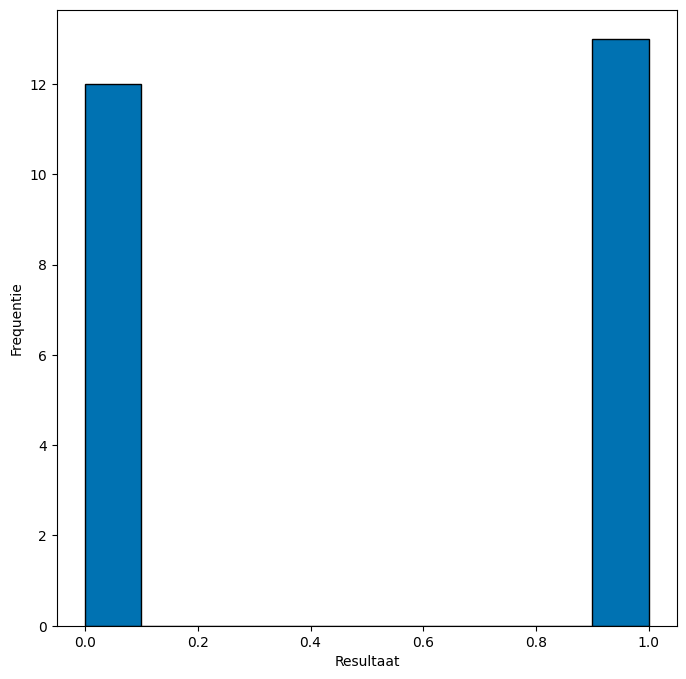

In [298]:
fig, ax = plt.subplots(figsize=(8,8))
df.resultaat.plot(kind='hist',ax=ax, edgecolor='black')
ax.set_ylabel('Frequentie')
ax.set_xlabel('Resultaat')

plt.show()

# Resultaten op snelheid

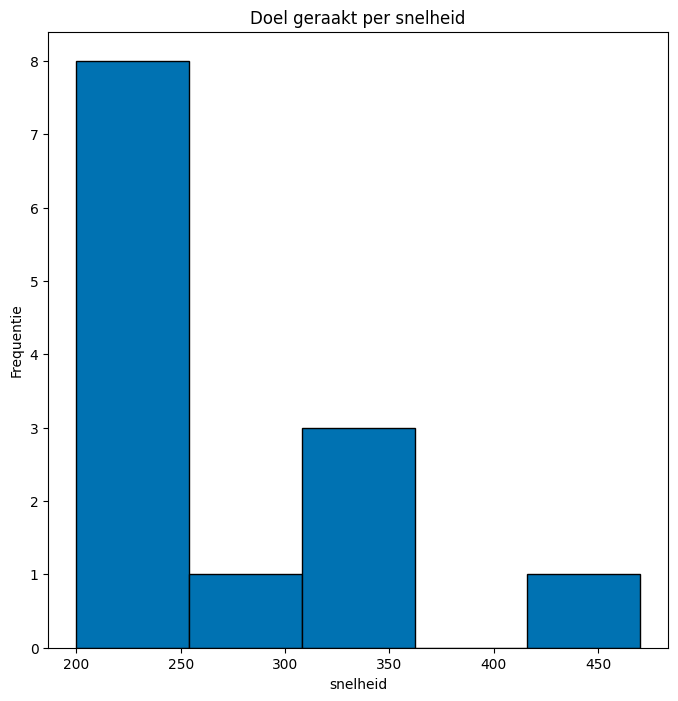

In [299]:
fig, ax = plt.subplots(figsize=(8,8))
df.query('resultaat == 1').doel.plot(kind='hist', ax=ax,edgecolor='black', bins=5, title='Doel geraakt per snelheid')
ax.set_xlabel('snelheid')
ax.set_ylabel('Frequentie')

plt.show()

Bij lage snelheden wordt het doel vaak geraakt, terwijl bij hoge snelheden het doel niet geraakt wordt.
- treshhold ligt ongeveer bij 350 knopen, dus dataset bekijken voor en na deze snelheid.

# Analyse bij snelheden <350 knopen
## Doel geraakt bij snelheid <350 knopen

In [300]:
df.query('doel < 350').resultaat.value_counts()

1    12
0     2
Name: resultaat, dtype: int64

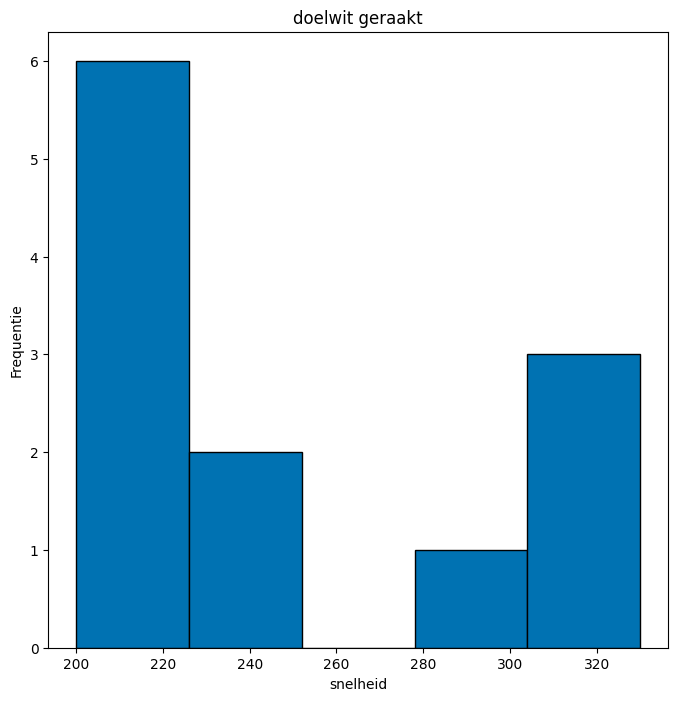

In [301]:
fig, ax = plt.subplots(figsize=(8,8))
df.query('doel < 350 and resultaat == 1').doel.plot(kind='hist',ax=ax, bins=5, edgecolor='black', title="doelwit geraakt")
ax.set_xlabel('snelheid')
ax.set_ylabel('Frequentie')
plt.show()

- 12 doelen geraakt
- 2 gemist

## Bij welke snelheid gemist?

In [302]:
df.query('doel < 350 and resultaat ==0').doel

5     270
18    230
Name: doel, dtype: int64

- 270 knopen
- 230 knopen

# Snelheden > 350 knopen anaylseren

In [303]:
df.query('doel > 350').resultaat.value_counts()

0    10
1     1
Name: resultaat, dtype: int64

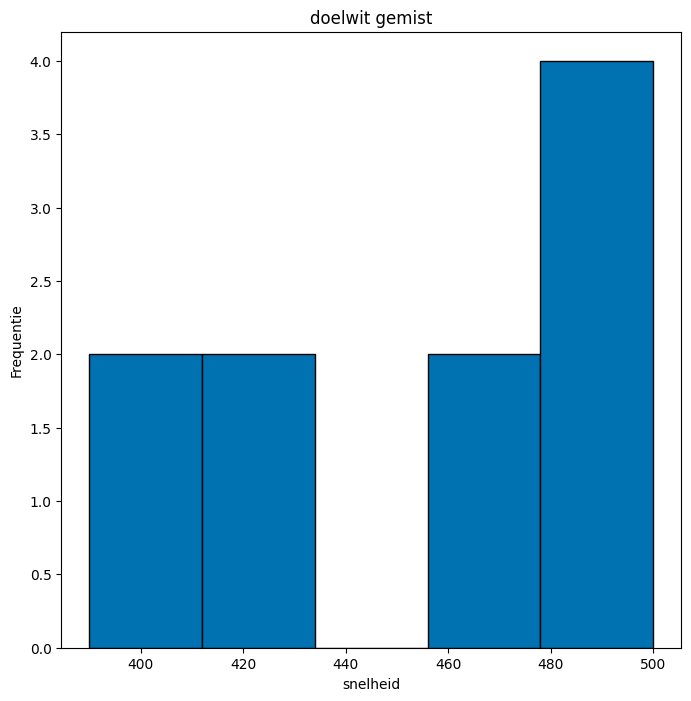

In [304]:
fig, ax = plt.subplots(figsize=(8,8))
df.query('doel > 350 and resultaat == 0').doel.plot(kind='hist',ax=ax, bins=5, edgecolor='black', title="doelwit gemist")
ax.set_xlabel('snelheid')
ax.set_ylabel('Frequentie')
plt.show()

- 1 keer geraakt
- 10 keer gemist

## Bij welke snelheid doelwit geraakt

In [305]:
df.query('doel > 350 and resultaat == 1').doel

17    470
Name: doel, dtype: int64

Doelwit is geraakt bij 470 knopen, maar lijkt als een uitschieter aangezien voor snelheden boven de 350 knopen het doelwit verder nooit geraakt is.

# Analyse van duplicates

- Zijn er meerdere metingen bij een zelfde snelheid uitgevoerd?
- Zijn er verschillen tussen deze metingen? 

In [306]:
df.doel.value_counts()

310    2
220    2
200    2
470    2
480    2
210    2
330    1
250    1
460    1
430    1
230    1
280    1
400    1
420    1
240    1
270    1
500    1
490    1
390    1
Name: doel, dtype: int64

Dataset lijkt unbalanced, aangezien er bij sommige snelheden een dubbele meting uitgevoerd is. Over het algemeen wordt er maar 1 meting per snelheid uitgevoerd.

## Zijn er verschillen tussen de gedupliceerde metingen?

In [307]:
dups = df.doel[df.doel.duplicated()].tolist()
dups.sort()

In [308]:
df.resultaat[df.doel==dups[0]].tolist()

[1, 1]

In [309]:
for i in dups:
    print(i, " :", df.resultaat[df.doel==i].values)

200  : [1 1]
210  : [1 1]
220  : [1 1]
310  : [1 1]
470  : [0 1]
480  : [0 0]


In [310]:
1960/1.852

1058.3153347732182

Alleen bij 470 knopen is er een gemixt resultaat. Aangezien doelwitten > 350 knopen bijna nooit geraakt worden lijkt het erop dat deze een afzwaaier was.

Het lijkt er dus op dat met deze raket doelwitten die sneller gaan dan 350 knopen niet uit de lucht kunnen worden gehaald. Het is dus eigenlijk gewoon een hele slechte raket aangezien de topsnelheid van een F-35 jsf rond mach 1.6 (1050 knopen) ligt.

# Uitschieters

- Boxplot maken om uitschieters te herkennen

<Axes: xlabel='resultaat', ylabel='doel'>

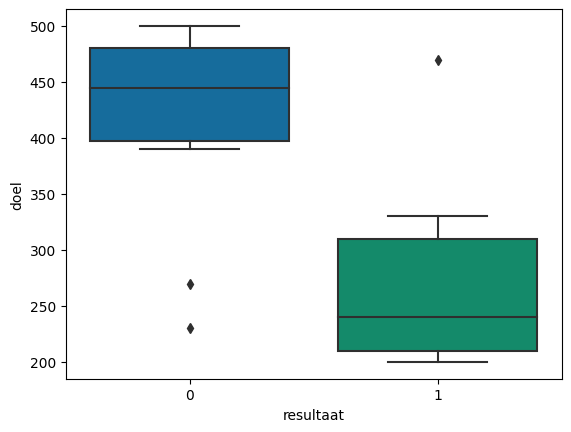

In [311]:
sns.boxplot(data=df, y='doel', x='resultaat')

- in de mis-categorie 2 uitschieters
- in de raak-categorie 1 uitschieter
    - lijkt erop dat dit ook de vooraf gevonden uitschieters zijn bij 230, 270 en 470 knopen

In [312]:
q1 = df.query('resultaat==0').doel.quantile(0.25)
q3 = df.query('resultaat==0')["doel"].quantile(0.75)

IQR = q3-q1

outliers = df.query('resultaat==0')["doel"][((df["doel"]<(q1-1.5*IQR)) | (df["doel"]>(q3+1.5*IQR)))]
outliers


5     270
18    230
Name: doel, dtype: int64

In [313]:
q1 = df.query('resultaat==1').doel.quantile(0.25)
q3 = df.query('resultaat==1')["doel"].quantile(0.75)

IQR = q3-q1

outliers = df.query('resultaat==1')["doel"][((df["doel"]<(q1-1.5*IQR)) | (df["doel"]>(q3+1.5*IQR)))]
outliers

17    470
Name: doel, dtype: int64

De uitschieters zijn inderdaad:
- 230
- 270
- 470

# regressie

Voor de regressie wordt gebruikt gemaakt van de Sigmoïd-functie

$$f(x) = \frac{1}{1 + e^{-z}}$$

met z

$$z = \beta_1 \cdot x + \beta_0$$

De Sigmoïd-functie kan omgeschreven worden naar $z$

$$\beta_1 \cdot x + \beta_0 = \ln\left(\frac{f(x)}{1-f(x)}\right)$$

Hierbij is de rechter zijde van de functie de logit-functie. Ook moet eraan gedacht worden,, dat de Sigmoid-functie altijd een **kans** beschrijft. Het logistische regressie algortime bepaald de kans $f(x)$ en voert vervolgens een lineaire regressie uit. Hieruit volgen de coëfficiënten $\beta_0$ en $\beta_1$. 

In [314]:
X = df.doel.values
X = X.reshape(-1,1)
y = df.resultaat.values

In [315]:
from sklearn.linear_model import LogisticRegression

In [316]:
lr = LogisticRegression()
model = lr.fit(X, y)
model.intercept_
model.coef_

array([[-0.01766362]])

In [317]:
a = model.coef_
b = model.intercept_
a,b

(array([[-0.01766362]]), array([6.06576403]))

$$\beta_0 = 6,06$$
$$\beta_1 = -0,02$$

Het gevonden model krijgt dus de vorm

$$f(x) = \frac{1}{1+e^{-\left(-0,02 \cdot x + 6,06\right)}}

In [318]:
df_sort = df.sort_values(by=['doel'])

In [319]:
snelheid = df_sort.doel.values
linmodel = a*snelheid + b
linmodel = linmodel[0]
sig = 1 / (1 + np.exp(-(linmodel)))
df_sort['sig'] = sig


In [320]:

probability = []
for i in range(1,21):
    k = (0.52)**i * (0.48)**(20-i)
    probability.append(1- k)

probability


[0.9999995433464336,
 0.9999995052919698,
 0.9999994640663006,
 0.9999994194051589,
 0.9999993710222556,
 0.9999993186074435,
 0.9999992618247304,
 0.9999992003101246,
 0.9999991336693017,
 0.9999990614750768,
 0.9999989832646665,
 0.9999988985367221,
 0.9999988067481156,
 0.9999987073104586,
 0.9999985995863301,
 0.999998482885191,
 0.9999983564589568,
 0.9999982194972032,
 0.9999980711219703,
 0.9999979103821344]

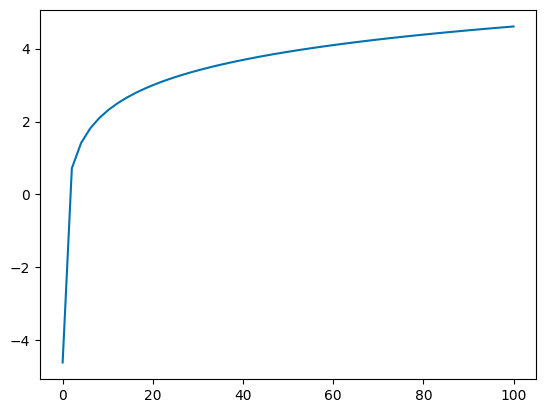

In [321]:
x = np.linspace(0.01, 100)
y = np.log(x)

plt.plot(x, y)

# Toetsing

Voor de toesting van het model wordt de F-test gebruikt. Hierbij wordt het verschil in variantie getoetst (net als bij ANOVA). Volgende hypothese wordt gesteld.

H0:
$$\tau_i = \hat{\tau}_i$$

H1:
$$\tau_i \neq \hat{\tau}_i$$

met $\tau_i$ het variantie van de meting en $\hat{\tau}_i$ de variantie van het model. In dit geval wordt tweezijdig getoetst met een 95%-betrouwbaarheidsinterval ($\alpha = 0,05$).

In [322]:
import scipy.stats

In [323]:
def F_test(group1, group2):
    F = group1.var()/group2.var()
    df1 = group1.size - 1
    df2 = group2.size - 1
    p = 1 - scipy.stats.f.cdf(F, df1, df2)
    return F, p


In [324]:
F_test(df.resultaat.values, sig)

(2.026211740492827, 0.045064962021569954)

Aangezien de F-test tweezijdig is, moet $p$ groter zijn dan $\alpha/2$, which is the case. Er blijkt dus volgens de F-test geen significant verschil in varianties te zijn. De nul-hypothese wordt dus aangenomen en dus ook de aanname dat het model klopt.

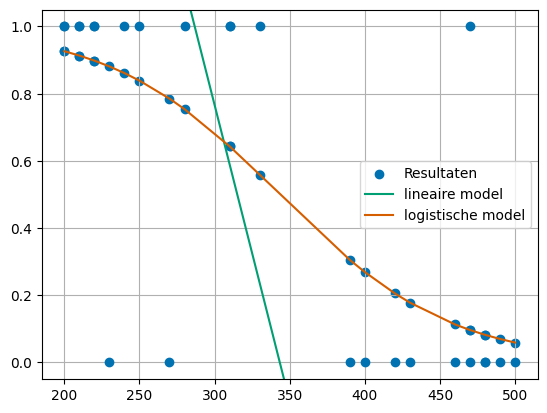

In [325]:
sig_meting = 1/(1+np.exp(-(b + a*df.doel.values)))

fig ,ax = plt.subplots()
ax.grid(True)

ax.scatter(df.doel.values, df.resultaat.values, zorder=3, color='C0', label='Resultaten')
ax.scatter(df.doel.values, sig_meting)
ax.plot(snelheid, linmodel, color='C1', label='lineaire model')
ax.plot(snelheid, sig, color='C2', label='logistische model')

ax.set_ylim([-0.05, 1.05])
ax.legend()
plt.show()


In [326]:
from sklearn.calibration import calibration_curve

resultaat = df.resultaat.values.tolist()
resultaat.sort(reverse=True)
test, mean_test = calibration_curve(resultaat, sig, n_bins=25)
mean_test = mean_test.tolist()
mean_test.sort(reverse=True)


In [338]:
x = df.doel.values.tolist()

y = 1/(1 + np.exp(-(b + a * x)))

odds = 0.52

res = df.resultaat.values.tolist()

y -odds

((res - y)/(np.sqrt(y*(1-y))))/0.52



array([[-1.16659001,  0.59198398, -0.52688245,  0.64664513, -0.48234488,
        -3.67745197,  0.54194336, -0.6286745 , -0.57553241,  1.43176103,
         0.77157497, -0.57553241, -0.97770117,  1.70837282,  1.09850582,
         0.59198398,  1.43176103,  5.88257492, -5.23565766, -0.89505573,
        -0.68672349,  0.64664513,  0.84281875,  0.54194336, -1.27430771]])